# Initializing a Random System

## Overview

### Questions

* How can I generate a random initial condition?
* What units does HOOMD-blue use?

### Objectives

* Describe the **units** HOOMD employs in molecular dynamics simulations.
* Demonstrate how to place particles on an initial lattice and **randomize** the configuration with an MD simulation.
* Explain why initial random velocities are important when using the **NVT** integration method.
* Show how to use **ThermodynamicQuantities** to compute properties of the system.
* Address the difference between **kinetic temperature** and **temperature**.

## Boilerplate code

In [1]:
import itertools
import math

import gsd.hoomd
import hoomd
import numpy

In [2]:
import os

fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"
fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [3]:
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Procedure

One effective way to initialize a random configuration of particles is to start with a low density non-overlapping configuration and run a simulation that compresses the system to the target density.
This section of the tutorial will place particles on a simple cubic lattice and run a short simulation allowing them to relax into the fluid state.

## Units

You need to know what system of **units** HOOMD-blue uses so that you can place particles at appropriate separations in the initial configuration.

HOOMD-blue does not adopt any particular real system of **units**. 
Instead, HOOMD-blue uses an *internally self-consistent* system of **units** and is compatible with *many systems of units*.
For example: if you select the units of *meter*, *Joule*, and *kilogram* for length, energy and mass then the units of force will be *Newtons* and velocity will be *meters/second*.
A popular system of units for nano-scale systems is *nanometers*, *kilojoules/mol*, and *atomic mass units*.

In molecular dynamics, the primary **units** are *length*, *energy*, and *mass*.
Other units are derived from these, for example $[\mathrm{pressure}] = \left(\frac{\mathrm{[energy]}}{\mathrm{[length]}^3}\right)$ and $[\mathrm{time}] = \sqrt{\frac{\mathrm{[mass]}\cdot\mathrm{[length]}^2}{\mathrm{[energy]}}}$.
Some quantities involve physical constants as well, such as *charge* which has units of $\sqrt{4\pi\epsilon_0\cdot\mathrm{[length]}\cdot\mathrm{[energy]}}$ (where $\epsilon_0$ is the permittivity of free space), and thermal energy $kT$ (where *k* is Boltzmann's constant).
HOOMD-blue never uses the temperature *T* directly. Instead it always appears indirectly in the value $kT$ which has units of energy.

HOOMD-blue does not perform unit conversions.
You provide all parameters in this system of units and all outputs will be given in these units.
The documentation for each property and parameter will list the units.
For the parameters set in this tutorial so far, the integrator's `dt` is in time units, the pair potentials `epsilon` is in energy units while `sigma` and `r_cut` are in length units.

You can interpret these values in the nano-scale units mentioned previously:

Unit | Value
--- | --- 
**\[length\]** | nanometer
**\[energy\]** | kilojoules/mol
**\[mass\]** | atomic mass unit
\[time\] | picoseconds
\[volume\] | cubic nanometers
\[velocity\] | nm/picosecond
\[momentum\] | amu nm/picosecond
\[acceleration\] | nm/picosecond^2
\[force\] | kilojoules/mol/nm
\[pressure\] | kilojoules/mol/nm^3
*k* | 0.0083144626181532 kJ/mol/Kelvin

For example, the values used in this tutorial could represent a system with 1 nanometer diameter particles that interact with a well depth of 1 kilojoule/mol at a thermal energy pf 1.5 kilojoules/mol (which implies $T \approx 180$ Kelvin).

## Initial condition

The Lennard-Jones system self-assembles the the fcc structure at moderately high densities.
To keep this tutorial's run time short, it simulates a small number of particles commensurate with the *fcc* structure (`4 * m**3`, where *m* is an integer).

In [4]:
m = 4
N_particles = 4 * m**3

In molecular dynamics, particles can theoretically have any position in the periodic box.
However, the steepness of the Lennard-Jones potential near $r \approx \sigma$ leads to extremely large forces that destabilize the numerical integration method.
Practically, you need to choose an initial condition with particles where their hard cores do not overlap.
The Lennard-Jones potential used in this tutorial represents a sphere with diameter ~1, so place particles a little bit further than that apart on a *K*x*K*x*K* simple cubic lattice of width *L*.
Later, this section will run an MD simulation allowing the particles to expand and fill the box randomly.

This is the same code you used in [Introducing HOOMD-blue tutorial](../00-Introducing-HOOMD-blue/03-Initializing-the-System-State.ipynb). See that tutorial for a more detailed description.

In [5]:
spacing = 1.3
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles]
snapshot.particles.typeid = [0] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]

The single particle type needs a name. 
Call it *A* because it is short and the first letter of the alphabet:

In [6]:
snapshot.particles.types = ['A']

Here is what the system looks like now:

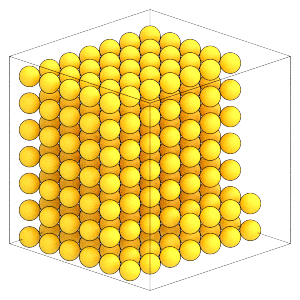

In [7]:
render(snapshot)

Write this snapshot to `lattice.gsd`:

In [8]:
with gsd.hoomd.open(name='lattice.gsd', mode='xb') as f:
    f.append(snapshot)

## Initialize the simulation

Configure this simulation to run on the CPU:

In [9]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(filename='lattice.gsd')

The simulation seed will be used when randomizing velocities later in the notebook.

Set up the molecular dynamics simulation, as discussed in the previous section of this tutorial:

In [10]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)

Assign the integrator to the simulation:

In [11]:
sim.operations.integrator = integrator

## Setting random velocities

In HOOMD-blue, velocities default to 0:

In [12]:
#snapshot = sim.state.snapshot()
#snapshot.particles.velocity[0:5]

When using the **NVT** integration method, you must specify non-zero initial velocities.
**NVT** modifies particle velocities by a scale factor so it cannot scale a zero velocity to a non-zero one.
The ``thermalize_particle_momenta`` method will assign Gaussian distributed velocities consistent with the the canonical ensemble.
It also sets the velocity of the center of mass to 0:

In [13]:
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

You can inspect the snapshot to see the changes that `thermalize_particle_momenta` produced.
Use the **ThermodynamicQuantities** class to compute properties of the system:

In [14]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

**ThermodynamicQuantities** is a **Compute**, an **Operation** that computes properties of the system state.
Some computations can only be performed during or after a simulation run has started.
Add the compute to the operations list and call `run(0)` to make all all properties available without changing the system state:

In [15]:
sim.operations.computes.append(thermodynamic_properties)
sim.run(0)

There are $(3 N_{\mathrm{particles}} - 3)$ degrees of freedom in the system.
The **NVT** integration method conserves linear momentum, so the `- 3` accounts for the effectively pinned center of mass.

In [16]:
thermodynamic_properties.degrees_of_freedom

765.0

Following the equipartition theorem, the average kinetic energy of the system should be approximately $\frac{1}{2}kTN_{\mathrm{dof}}$.

In [17]:
1 / 2 * 1.5 * thermodynamic_properties.degrees_of_freedom

573.75

In [18]:
thermodynamic_properties.kinetic_energy

566.7599495184155

Why isn't this exactly equal? Doesn't this kinetic energy correspond to a different temperature than was set?

In [19]:
thermodynamic_properties.kinetic_temperature

1.4817253582180796

No, it doesn't. The instantaneous **kinetic temperature** $T_k$ ($kT_k$ in energy units here) of a finite number of particles fluctuates! The canonical ensemble holds the number of particles, volume, and the thermodynamic temperature constant. Other thermodynamic quantities like kinetic energy (and thus kinetic temperature) will fluctuate about some average. Both that average and the scale of the fluctuations are well defined by statistical mechanics.

## Run the simulation

Run the simulation forward in time to randomize the particle positions.
As the simulation progresses, it will move from the initial highly ordered state to a random fluid that fills the box.

In [20]:
sim.run(10000)

Here is the final random configuration of particles:

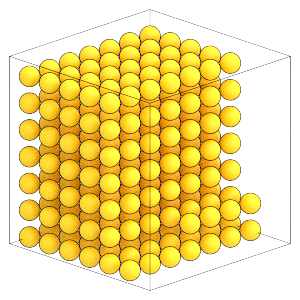

In [21]:
render(snapshot)

In [22]:
thermodynamic_properties.kinetic_energy

548.1915452917345

Here, you can see that the instantaneous kinetic energy of the system has taken on a different value.
Depending on the random number seed and other conditions when this notebook runs, this value may be smaller or larger than the expected average value, but it should remain relatively close to the expected average.

Now, you've created an initial random configuration of Lennard-Jones particles in a low density fluid.
Save the final configuration to a GSD file for use in the next stage of the simulation:

In [23]:
hoomd.write.GSD.write(state=sim.state, filename='random.gsd', mode='xb')

The next section of this tutorial will compress this initial condition to a higher density where it will assemble an ordered structure.